In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# plt.style.use('dark_background')
import h5py
import skopt
import scipy as sc
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
%run ./Functions_Test.ipynb
%run ./Val_Functions.ipynb
import matplotlib as mpl
import time
import math
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

## Prediction Horizon of Extreme Events

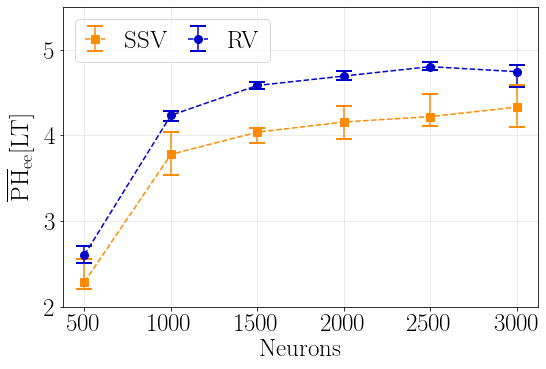

In [7]:
plt.rcParams["figure.figsize"] = (7.5,5)
plt.rcParams["font.size"] = 25

plt.figure()
ax = plt.subplot(111)

NN_units  = [500,1000,1500,2000,2500,3000]
SNRs      = [40]
Re        = 400
un_length = len(NN_units)

a_RVC     = np.zeros((un_length,3))
a_SSV     = np.zeros((un_length,3))

markers = ['s', 'o', '^', 'v']
labels  = ['RV', 'SSV']
colors  = ['mediumblue', 'darkorange']


k = 0
for target_snr_db in SNRs:
    i         = 0
    for N_units in NN_units:

        fln   = './../data/'+ str(Re) + '_' + 'RVC_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf    = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('PH'))
        t_RVC = t_RVC.mean(axis=1)
        hf.close()
        
        fln   = './../data/'+ str(Re) + '_' + 'SSV_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        
        hf    = h5py.File(fln,'r')
        t_SSV = np.array(hf.get('PH'))
        t_SSV = t_SSV.mean(axis=1)
        hf.close()
        
        q1 = .25
        q2 = 1 - q1

        a_RVC[i] = [np.quantile(t_RVC,q1,axis=0),np.median(t_RVC,axis=0),np.quantile(t_RVC,q2,axis=0)]
        a_SSV[i] = [np.quantile(t_SSV,q1,axis=0),np.median(t_SSV,axis=0),
                    np.quantile(t_SSV,q2,axis=0)]
        i +=1


    x = NN_units
    plt.xticks(x)

    plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)


    plt.errorbar(x, a_SSV[:,1], 
                 yerr = np.array([a_SSV[:,1] - a_SSV[:,0],
                                  a_SSV[:,2] - a_SSV[:,1]]), 
                 linestyle='--',color=colors[1], marker=markers[0], markersize=8,
                 capsize=8, capthick=2, label=labels[1], alpha=1)
    plt.errorbar(x, a_RVC[:,1], 
                 yerr = np.array([a_RVC[:,1] - a_RVC[:,0],
                                  a_RVC[:,2] - a_RVC[:,1]]), 
                 linestyle='--',color=colors[0], marker=markers[1], markersize=8,
                 capsize=8, capthick=2, label=labels[0], alpha=1)
    k+=1

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
plt.ylabel('$\overline{\mathrm{PH}}_{\mathrm{ee}}$[LT]', labelpad=10)
plt.xlabel('Neurons')
plt.legend(ncol=2, frameon=True, columnspacing=0.8, handlelength=0.8, loc='upper left')
plt.ylim(2.0,5.5)


plt.tight_layout(pad=0.1)
# plt.savefig('Noise_PHEE.pdf')


## Precision - Recall

/home/ar994/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ar994/.local/lib/python3.6/site-packages/ipykernel_launcher.py:258: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(10, 10, 5)


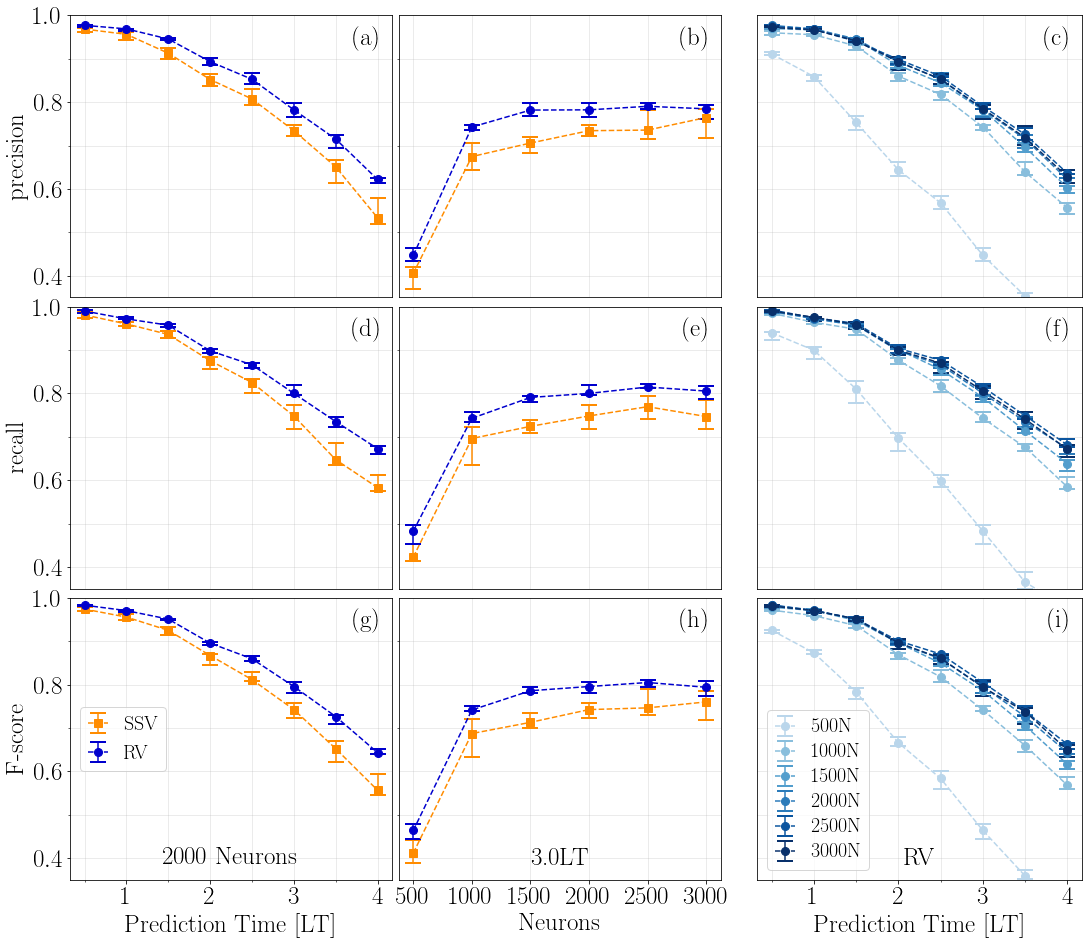

In [9]:
NN_units = [2000]
Re       = 400

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [SSV,RVC]

from matplotlib.gridspec import *
plt.rcParams["figure.figsize"] = (15,13)
plt.rcParams["font.size"] = 25

colors  = ['darkorange', 'mediumblue']
markers = ['s', 'o']
letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

pr_max = 3
labels_pr = ['precision','recall','F-score']
labels    = ['SSV', 'RV']
axx = plt.figure()
gs = GridSpec(pr_max, 2, width_ratios=[2., 1.], figure=axx, wspace=0.1,hspace=0.02)

gss = [None]*pr_max

for pr in range(pr_max):
    gss[pr] = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.], subplot_spec=gs[pr*2],
                                     wspace=0.02)

logg  = False
fg    = 0
if logg:
    fg = 1

k_t     = 0
for val in vals:

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

        fln = './../data/'+ str(Re) + '_'+ val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()


        ensemble = t_RVC.shape[0]
        LT_range = t_RVC.shape[1] - 2

        p_RVC = np.zeros((ensemble, LT_range))
        r_RVC = np.zeros((ensemble, LT_range))
        F_RVC = np.zeros((ensemble, LT_range,3))

        x = .5 + .5*np.arange(LT_range)
        xx = x.copy()

        for i in range(ensemble):
            for j in range(LT_range):

                TN,FN,FP,TP,summ = t_RVC[i,j]
                F_RVC[i,j,0] = np.abs(fg - TP/(TP+FP))
                F_RVC[i,j,1] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j,2] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

        q1 = .25
        q2 = 1 - q1

        for pr in range(pr_max):
            
            ax = axx.add_subplot(gss[pr][0])
            if pr < pr_max-1:
                plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
            
            plt.ylim(0.35,1.)
            plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))

            plt.errorbar(x, np.median(F_RVC[:,:,pr],axis=0), 
                         yerr = np.array([np.median(F_RVC[:,:,pr],axis=0) - np.quantile(F_RVC[:,:,pr],q1,axis=0),
                                          - np.median(F_RVC[:,:,pr],axis=0) + np.quantile(F_RVC[:,:,pr],q2,axis=0)]), 
                         linestyle='--', marker=markers[k_t], markersize=8, c=colors[k_t],
                         capsize=8, capthick=2, label=labels[k_t], alpha=1)

            
            if k_t == 0 and ii == 0:
                plt.annotate(letter[0+3*pr], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')

            
            plt.ylabel(labels_pr[pr])
            
        plt.xlabel('Prediction Time [LT]')
        plt.xticks(x[1::2])

        k_t +=1

plt.annotate(str(N_units) + ' Neurons', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
     xycoords='axes fraction', textcoords='offset points')
plt.legend(ncol=1, columnspacing=0.7, handlelength=1, loc='center left', fontsize=20)

    
    

NN_units  = [500,1000,1500,2000,2500,3000]
un_length = len(NN_units)

print(t_RVC.shape)

k = 0
N_LT   = 10
t1_RVC = np.zeros((un_length,t_RVC.shape[0],N_LT,t_RVC.shape[2]))
t1_SSV = np.zeros((un_length,t_RVC.shape[0],N_LT,t_RVC.shape[2]))

colors  = ['darkorange', 'mediumblue']
markers = ['s', 'o']

for N_units in NN_units:


    fln = './../data/'+ str(Re) + '_RVC_Prec_Recall_40_'+  str(N_units) +'.h5'
    hf = h5py.File(fln,'r')
    t1_RVC[k] = np.array(hf.get('temp'))[:,:N_LT]
    hf.close()

    fln = './../data/'+ str(Re) + '_SSV_Prec_Recall_40_'+  str(N_units) +'.h5'
    hf = h5py.File(fln,'r')
    t1_SSV[k] = np.array(hf.get('temp'))[:,:N_LT]
    hf.close()

    
    k +=1

p_RVC = np.zeros((un_length,ensemble, LT_range))
r_RVC = np.zeros((un_length,ensemble, LT_range))
F_RVC = np.zeros((3,un_length,ensemble, LT_range))

p_SSV = np.zeros((un_length,ensemble, LT_range))
r_SSV = np.zeros((un_length,ensemble, LT_range))
F_SSV = np.zeros((3,un_length,ensemble, LT_range))


logg  = False
fg    = 0
if logg:
    fg = 1

for k in range(un_length):
    for i in range(ensemble):
        for j in range(LT_range):

            TN,FN,FP,TP,summ = t1_RVC[k,i,j]
            F_RVC[0,k,i,j] = np.abs(fg - TP/(TP+FP))
            F_RVC[1,k,i,j] = np.abs(fg - TP/(TP+FN))
            F_RVC[2,k,i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

            TN,FN,FP,TP,summ = t1_SSV[k,i,j]
            F_SSV[0,k,i,j] = np.abs(fg - TP/(TP+FP))
            F_SSV[1,k,i,j] = np.abs(fg - TP/(TP+FN))
            F_SSV[2,k,i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )
            

            
PLT = 5
q1  = .25
q2  = 1 - q1

x = NN_units

for pr in range(pr_max):
    
    ax = axx.add_subplot(gss[pr][1])
    if pr < pr_max-1:
                plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
    plt.xticks(x)

    plt.ylim(.35,1)
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
    plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
    plt.tick_params(axis='y', which='major', left=False, right=False, labelleft=False)

    plt.errorbar(x, np.median(F_SSV[pr,:,:,PLT],axis=1), 
             yerr = np.array([np.median(F_SSV[pr,:,:,PLT],axis=1) - np.quantile(F_SSV[pr,:,:,PLT],q1,axis=1),
                              - np.median(F_SSV[pr,:,:,PLT],axis=1) + np.quantile(F_SSV[pr,:,:,PLT],q2,axis=1)]), 
             linestyle='--',color=colors[0], marker=markers[0], markersize=8,
             capsize=8, capthick=2, label='SSV', alpha=1)


    plt.errorbar(x, np.median(F_RVC[pr,:,:,PLT],axis=1), 
             yerr = np.array([np.median(F_RVC[pr,:,:,PLT],axis=1) - np.quantile(F_RVC[pr,:,:,PLT],q1,axis=1),
                              - np.median(F_RVC[pr,:,:,PLT],axis=1) + np.quantile(F_RVC[pr,:,:,PLT],q2,axis=1)]), 
             linestyle='--',color=colors[1], marker=markers[1], markersize=8,
             capsize=8, capthick=2, label='RV', alpha=1)


    plt.annotate(letter[1+3*pr], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')




plt.xlabel('Neurons')

plt.annotate(str(xx[PLT]) + 'LT', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')



NN_units = [500,1000,1500,2000,2500,3000]

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [RVC]


colors = [pl.cm.Blues(np.linspace(0,1,len(NN_units)+2))] 

k_t     = 0
for val in vals:

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

        fln = './../data/'+ str(Re) + '_' + val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()

        p_RVC = np.zeros((ensemble, LT_range))
        r_RVC = np.zeros((ensemble, LT_range))
        F_RVC = np.zeros((ensemble, LT_range,3))

        x = .5 + .5*np.arange(LT_range)

        logg  = False
        fg    = 0
        if logg:
            fg = 1
            plt.yscale('log')


        for i in range(ensemble):
            for j in range(LT_range):

                TN,FN,FP,TP,summ = t_RVC[i,j]
                F_RVC[i,j,0] = np.abs(fg - TP/(TP+FP))
                F_RVC[i,j,1] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j,2] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )


        q1 = .25
        q2 = 1 - q1

        for pr in range(pr_max):
            
            ax = axx.add_subplot(gs[1+2*pr])
            if pr < pr_max-1:
                plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
            plt.ylim(0.35,1.)
            plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

            plt.errorbar(x, np.median(F_RVC[:,:,pr],axis=0), 
                         yerr = np.array([np.median(F_RVC[:,:,pr],axis=0) - np.quantile(F_RVC[:,:,pr],q1,axis=0),
                                          - np.median(F_RVC[:,:,pr],axis=0) + np.quantile(F_RVC[:,:,pr],q2,axis=0)]), 
                         linestyle='--', marker='o', markersize=8, c=colors[0][ii+2],
                         capsize=8, capthick=2, label=str(N_units) + 'N', alpha=1)

            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)      
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))
            if k_t == 0 and ii == 0:
                plt.annotate(letter[2+3*pr], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')

    plt.legend(ncol=1, columnspacing=0.7, handlelength=1, loc='lower left', fontsize=20,
               labelspacing=0.3)
    plt.xlabel('Prediction Time [LT]')
    plt.xticks(x[1::2])

            
    k_t +=1

plt.annotate('RV', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')

gs.tight_layout(axx,pad=.1,w_pad=1.,h_pad=0.02)
# plt.savefig('Prec_Rec_comparison1.pdf')

## Other Reynolds

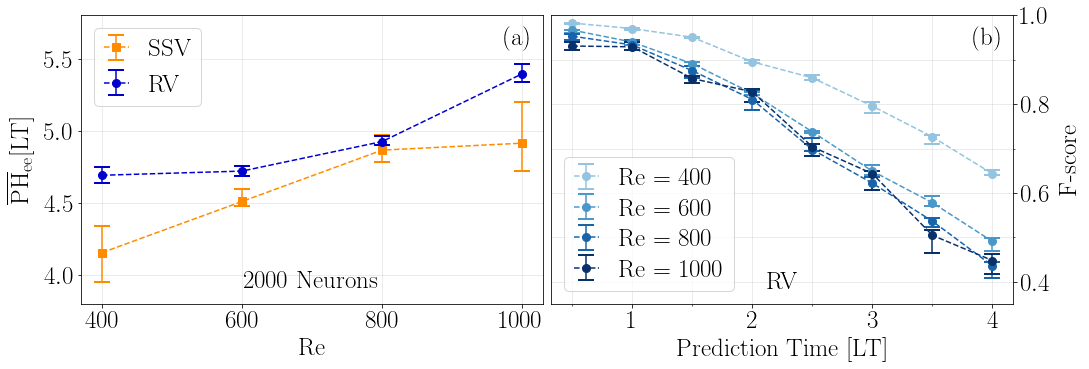

In [11]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25

plt.figure()
ax = plt.subplot(121)

Reys      = [400,600,800,1000]
NN_units  = [2000] #add 3500 for tikhonov up to 10e-11
SNRs      = [40]
un_length = len(NN_units)
Re_length = len(Reys)

a_RVC     = np.zeros((Re_length,3))
a_RVC4    = np.zeros((Re_length,3))
a_SSV     = np.zeros((Re_length,3))

markers = ['s', 'o', '^', 'v']
labels  = ['RV','SSV']
colors  = ['mediumblue', 'darkorange', 'coral', 'violet']

norm    = np.ones(un_length)#np.array([0.0159,0.0136,0.0126,0.0121])/0.0296


k = 0
for Re in Reys:
    for target_snr_db in SNRs:
        i         = 0
        for N_units in NN_units:


            fln   = './../data/'+str(Re)+'_RVC_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
            hf    = h5py.File(fln,'r')
            t_RVC = np.array(hf.get('PH'))
            t_RVC = t_RVC.mean(axis=1)
            hf.close()
            
            fln   = './../data/'+str(Re)+'_SSV_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
            hf    = h5py.File(fln,'r')
            t_SSV = np.array(hf.get('PH'))
            t_SSV = t_SSV.mean(axis=1)
            hf.close()
    
            q1 = .25
            q2 = 1 - q1

            a_RVC[k] = [np.quantile(t_RVC,q1,axis=0),np.median(t_RVC,axis=0),
                        np.quantile(t_RVC,q2,axis=0)]
            a_SSV[k] = [np.quantile(t_SSV,q1,axis=0),np.median(t_SSV,axis=0),
                        np.quantile(t_SSV,q2,axis=0)]
            i +=1


        x = Reys
        plt.xticks(x)

        plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

        if k ==0:
            plt.errorbar(x[k], a_SSV[k,1], 
                         yerr = np.array([a_SSV[k,1] - a_SSV[k,0],
                                          a_SSV[k,2] - a_SSV[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[1], marker=markers[0], markersize=8,
                         capsize=8, capthick=2, label=labels[1], alpha=1)
            plt.errorbar(x[k], a_RVC[k,1], 
                         yerr = np.array([a_RVC[k,1] - a_RVC[k,0],
                                          a_RVC[k,2] - a_RVC[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[0], marker=markers[1], markersize=8,
                         capsize=8, capthick=2, label=labels[0], alpha=1)
        else:
            plt.errorbar(x[k], a_SSV[k,1], 
                         yerr = np.array([a_SSV[k,1] - a_SSV[k,0],
                                          a_SSV[k,2] - a_SSV[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[1], marker=markers[0], markersize=8,
                         capsize=8, capthick=2, alpha=1)
            plt.errorbar(x[k], a_RVC[k,1], 
                         yerr = np.array([a_RVC[k,1] - a_RVC[k,0],
                                          a_RVC[k,2] - a_RVC[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[0], marker=markers[1], markersize=8,
                         capsize=8, capthick=2, alpha=1)

    k+=1

plt.plot(x, a_RVC[:,1], '--', color=colors[0])
plt.plot(x, a_SSV[:,1], '--', color=colors[1])
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
plt.ylabel('$\overline{\mathrm{PH}}_{\mathrm{ee}}$[LT]', labelpad=10)
plt.xlabel('Re')
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.ylim(3.8,5.8)
plt.annotate('2000 Neurons', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')
plt.legend(ncol=1, columnspacing=0.7, handlelength=1, loc='upper left', fontsize=25)

ax = plt.subplot(122)

NN_units = [400,600,800,1000]

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [RVC]
labels_pr = ['p','r','F-score']


colors = [pl.cm.Blues(np.linspace(0,1,len(NN_units)+2))] 

k_t     = 0
for val in vals:

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

        fln = './../data/' + str(N_units) + '_' + val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_2000.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()


        ensemble = t_RVC.shape[0]
        LT_range = t_RVC.shape[1] - 2

        F_RVC = np.zeros((ensemble, LT_range,3))

        x = .5 + .5*np.arange(LT_range)

        logg  = False
        fg    = 0
        if logg:
            fg = 1
            plt.yscale('log')


        for i in range(ensemble):
            for j in range(LT_range):

                TN,FN,FP,TP,summ = t_RVC[i,j]
                F_RVC[i,j,0] = np.abs(fg - TP/(TP+FP))
                F_RVC[i,j,1] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j,2] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

        q1 = .25
        q2 = 1 - q1

        pr = 2
            
        plt.ylim(0.35,1.)
        plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

        plt.errorbar(x, np.median(F_RVC[:,:,pr],axis=0), 
                     yerr = np.array([np.median(F_RVC[:,:,pr],axis=0) - np.quantile(F_RVC[:,:,pr],q1,axis=0),
                                      - np.median(F_RVC[:,:,pr],axis=0) + np.quantile(F_RVC[:,:,pr],q2,axis=0)]), 
                     linestyle='--', marker='o', markersize=8, c=colors[0][ii+2],
                     capsize=8, capthick=2, label='Re = ' + str(N_units), alpha=1)

        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        plt.ylabel(labels_pr[pr], labelpad=10)
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))

    plt.legend(ncol=1, columnspacing=0.7, handlelength=1, loc='lower left', fontsize=25,
               labelspacing=0.3)
    plt.xlabel('Prediction Time [LT]')
    plt.xticks(x[1::2])

            
    k_t +=1

plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.annotate('RV', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')


plt.tight_layout(pad=0.1)
# plt.savefig('OR.pdf')
